In [1]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Perform 16QAM symbol detection


In [2]:
# Number of QAM symbols to be transmitted.
N = 100000

In [3]:
mapping_table = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j, 3-1j, 3+3j, 3+1j, 1-3j, 1-1j, 1+3j, 1+1j]

def mod(bits):

    symbols = np.zeros((len(bits),1),dtype=complex)
    for i in range(0,len(bits)): 
        symbols[i] = mapping_table[bits[i]]/np.sqrt(10)
    
    return symbols

def to_one_hot(y):
    
    n_classes = y.max() + 1
    #m = len(y)
    m = np.zeros((len(y),1),dtype=complex)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    
    return Y_one_hot

def demod(c):
    c_seq = mod(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [4]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

SER_simu = np.zeros(len(EsN0dB))
SER_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
   
    print('Es/N0 dB:', EsN0dB[idx])
   
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
   
    # Generate N 4-bit symbols.
    bits = np.random.randint(0,16,N)
   
    # Modulate the binary stream into 16QAM symbols.
    symbols = mod(bits)
    
    # Normalization of energy to 1.
    symbols_norm = (1/np.sqrt(2))*symbols;
   
    # Generate noise vector.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
   
    y = symbols_norm + np.sqrt(EsN0Lin)*noise
   
    s_test, s_train, y_test, y_train, v_test, v_train = train_test_split(symbols, y, bits, random_state=42)
       
    # Define with GridSearchCV which is the best k = n_neighbors
    knn = KNeighborsClassifier(n_neighbors=20, weights='distance') 
    
    # Train model for knn
    knn.fit(s_train.real, v_train)
    
    # Fit model for imaginary part.
    knn.fit(s_train.imag, v_train)
   
    # Prediction.
    detected_re = knn.predict(s_test.real)
     
    # Prediction for imaginary part.
    detected_im = knn.predict(s_test.imag)
      
    #print(error)
    error_re = (v_test != detected_re) 
    error_im = (v_test != detected_im)
    error = 0;
    for i in range(0, len(v_test)): # Deve ser testar todosos N símbolos, neste caso o tamanho do conjunto de teste.  #v_test
        if(error_re[i]==True or error_im[i]==True): 
        #if(v_test[i] != detected_re):
            error = error + 1
            #print(error)

    SER_simu[idx] = 1.0 * error / len(v_test)
    
    # Theoretical BPSK BER.    
    SER_theo[idx] = 1.5*erfc((np.sqrt(10)/10)*np.sqrt(10.0**(EsN0dB[idx]/10.0))) - (9/16)*(erfc((np.sqrt(10)/10)*np.sqrt(10.0**(EsN0dB[idx]/10.0))))**2.0 
    

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [5]:
# Print values of Es/N0 vs. SER.
for i in range(0,len(SER_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], SER_simu[i]))

Es/N0:-2 	- SER: 9.382267e-01
Es/N0:0 	- SER: 9.374667e-01
Es/N0:2 	- SER: 9.397200e-01
Es/N0:4 	- SER: 8.768400e-01
Es/N0:6 	- SER: 9.377333e-01
Es/N0:8 	- SER: 9.362267e-01
Es/N0:10 	- SER: 9.379200e-01
Es/N0:12 	- SER: 9.381200e-01
Es/N0:14 	- SER: 8.757067e-01
Es/N0:16 	- SER: 1.000000e+00
Es/N0:18 	- SER: 8.762667e-01
Es/N0:20 	- SER: 9.370667e-01


## Theorical vs. Simulated SER curves

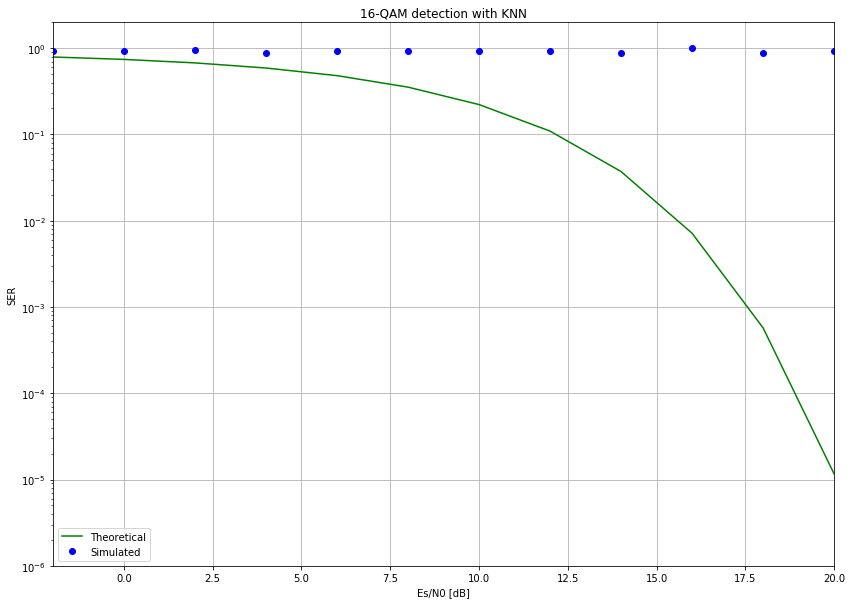

In [6]:
# Plot Es/N0 versus SER values.
fig = plt.figure(figsize=(14,10))
plt.plot(EsN0dB, SER_theo, 'g', label='Theoretical')
plt.plot(EsN0dB, SER_simu, 'bo', label='Simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('16-QAM detection with KNN')
plt.legend()
plt.xlim([-2, 20])
plt.ylim([1e-06, 2])
plt.show()